In [194]:
import numpy as np
#import sympy
import networkx as nx
import matplotlib.pyplot as plt
#from misc_tools.print_latex import print_tex
#from IPython.display import Latex

In [195]:
np.random.seed(1)
NUM_NODES = 4

G = nx.Graph()
G = nx.barbell_graph(3,0)

for n,c in zip(G.nodes, np.linspace(0,1,len(G.nodes))):
    G.nodes[n]['color'] = c

In [196]:
def plt_graph_undir(graph, ax):
    np.random.seed(1)
    #pos = nx.spring_layout(G, seed=1)
    pos = nx.shell_layout(G)
    cmap, ncs = None, None
    colors = list(nx.get_node_attributes(graph, "color").values())
    if len(colors) > 0:
        ncs  = colors
        cmap = plt.get_cmap('viridis')
        
    edge_labels = nx.get_edge_attributes(graph, "weight")

    nx.draw_networkx_nodes(         graph, pos, ax = ax, cmap=cmap, node_color=ncs)
    nx.draw_networkx_labels(        graph, pos, ax = ax, font_color='red', font_size= 15)
    nx.draw_networkx_edges(         graph, pos, ax = ax)
    nx.draw_networkx_edge_labels(   graph, pos, edge_labels, ax = ax, font_color="blue", font_size= 7)

    ax.set_title('Undirected')
    return 


`Convolution` on a graph is much more general than its regular data (1D signals, 2D images).

Notion of `kernel size` is related to distance of `message passing` from node to node, even in cases if they are not directly connected.

We can view this question though a lense of `Random Walk`

In [204]:
class ConvolveLayerGraph:
    def __init__(self, graph, node, recursion_max):
        # globals
        self.G              = nx.DiGraph()
        self.graph          = graph 
        self.nodes_set      = set()
        self.recursion_max  = recursion_max
        self.ID             = 0
        self.G.add_node(0)
        self.new_old_ID     = {}
        self.num_branches   = {i:0 for i in range(recursion_max + 1)}
        self.nodes_at_level = {i:set() for i in range(recursion_max + 1)}
        self.nodes_at_level[0].add(0)
        self.new_old_ID[0]  = node  

        # multilevel globals
        self.storage        = {}

        
        self.add_children(node, self.storage)
        
        self.set_node_pos()
        

    def add_children(self, node, storage, recursion = 0):
        if recursion >= self.recursion_max: return       # max depth reached

        neighbors = list(self.graph.neighbors(node))

        if len(neighbors) == 0: return              # no neighbors, no need to search (might be faulty)

        if node not in storage: storage[node] = {}

        self.num_branches[recursion] += 1

        self.nodes_set.add(node)

        og_new_ID = self.ID

        recursion_next = recursion + 1

        for n in neighbors:
            self.ID += 1    #
            self.new_old_ID[self.ID] = n
            self.G.add_edge(og_new_ID, self.ID)
            self.nodes_at_level[recursion_next].add(self.ID)
            self.add_children(n, storage[node], recursion_next)

        return 
    
    def set_node_pos(self):
        num_end_nodes = len(self.nodes_at_level[self.recursion_max])

        Lx, Ly = 5, 5
       
        x_pos_lowest    = np.linspace(- Lx/2, Lx/2, num_end_nodes)
        y_pos_all       = np.linspace(- Ly/2, Ly/2, self.recursion_max + 1)
        asd = list(self.nodes_at_level)[-2::-1]
        for l,L in enumerate(asd):
            i = 0
            parent_nodes = self.nodes_at_level[L]
            for pn in parent_nodes:                       # 1, 9
                child_nodes = list(self.G.neighbors(pn))  # 1:[*nb1], 9:[*nb9]
                
                if L == self.recursion_max - 1:
                    for cn in child_nodes:
                        self.G.nodes[cn]['pos'] = np.array([x_pos_lowest[i], y_pos_all[l]])
                        i += 1

                posx = [self.G.nodes[cn]['pos'][0] for cn in child_nodes]

                self.G.nodes[pn]['pos'] = np.array([np.mean(posx), y_pos_all[l + 1]])

layers = 3
a = ConvolveLayerGraph(G, 0, layers)


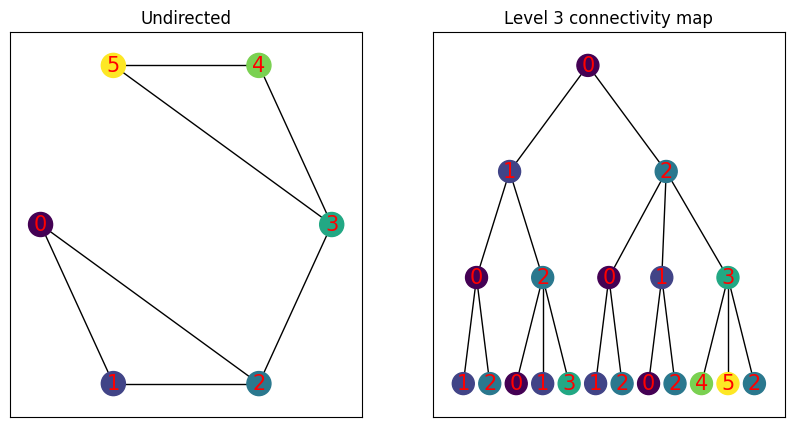

In [205]:
fig, ax = plt.subplots(1,2, figsize = (10,5))

plt_graph_undir(G,ax[0])

G2 = a.G.to_undirected()
pos = G2.nodes(data='pos')
color_dict = dict(nx.get_node_attributes(G, "color"))
clr_map = [color_dict[a.new_old_ID[n]] for n in G2.nodes]
nx.draw_networkx_nodes(G2, pos, ax = ax[1], node_size=250, cmap = plt.get_cmap('viridis'), node_color=clr_map)
nx.draw_networkx_labels(G2, pos, ax = ax[1], font_size= 15, labels=a.new_old_ID, font_color='r')
nx.draw_networkx_edges(G2, pos, ax = ax[1]);
ax[1].set_title(f'Level {layers} connectivity map');